In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'
print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.5
pandas 0.25.2
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
tf.test.is_gpu_available()

False

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
# print(fashion_mnist)
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]
# 打印格式
print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [5]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train:[None,28,28] -> [None,784]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)

In [6]:
# tf.keras.models.Sequential()
# 构建模型
model = keras.models.Sequential()

# 卷积神经网络
# 输入
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding="same",activation='selu',input_shape=(28,28,1)))

model.add(keras.layers.SeparableConv2D(filters=32,kernel_size=3,padding='same',activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.SeparableConv2D(filters=64,kernel_size=3,padding="same",activation='selu'))
model.add(keras.layers.SeparableConv2D(filters=64,kernel_size=3,padding='same',activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.SeparableConv2D(filters=128,kernel_size=3,padding="same",activation='selu'))
model.add(keras.layers.SeparableConv2D(filters=128,kernel_size=3,padding='same',activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

# 展平
model.add(keras.layers.Flatten())

# 全连接层
model.add(keras.layers.Dense(128,activation='relu'))

# 输出层
model.add(keras.layers.Dense(10,activation="softmax"))



# 
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 14, 14, 64)        2400      
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 14, 14, 64)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 7, 7, 128)         8

In [8]:
# 回调函数 Tensorboard(文件夹）\earylystopping\ModelCheckpoint（文件名）
logdir = os.path.join("separable_cnn-selu-callbacks")
print(logdir)
if not os.path.exists(logdir):
    os.mkdir(logdir)
# 文件名
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]
# 开始训练
history = model.fit(x_train_scaled,y_train,epochs=10,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)

separable_cnn-selu-callbacks
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 179s 3ms/sample - loss: 2.3025 - accuracy: 0.1033 - val_loss: 2.3021 - val_accuracy: 0.1728
Epoch 2/10
55000/55000 [==============================] - 175s 3ms/sample - loss: 2.3004 - accuracy: 0.1203 - val_loss: 2.2933 - val_accuracy: 0.1830
Epoch 3/10
55000/55000 [==============================] - 166s 3ms/sample - loss: 1.3647 - accuracy: 0.5404 - val_loss: 0.7508 - val_accuracy: 0.7196
Epoch 4/10
55000/55000 [==============================] - 160s 3ms/sample - loss: 0.7121 - accuracy: 0.7305 - val_loss: 0.6156 - val_accuracy: 0.7680
Epoch 5/10
55000/55000 [==============================] - 163s 3ms/sample - loss: 0.6197 - accuracy: 0.7652 - val_loss: 0.5914 - val_accuracy: 0.7806
Epoch 6/10
55000/55000 [==============================] - 161s 3ms/sample - loss: 0.5741 - accuracy: 0.7803 - val_loss: 0.5397 - val_accuracy: 0.7948
Epoch 7/10
55000/55000

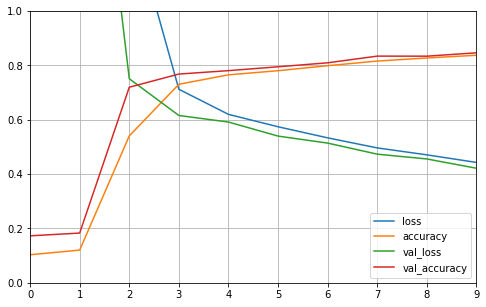

In [9]:
# 画图
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

# 损失函数，刚开始下降慢的原因
# 1. 参数众多，训练不充分
# 2. 梯度消失 -》 链式法则中
# 解决： selu缓解梯度消失

In [10]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4545343730688095, 0.8326]